In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import xarray as xr
from plotting_utils import *
from train import *
from MLP import *

parent_dir: /Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS
hi from MLP.py!2


In [2]:
input_data_60S_so = xr.open_dataset(f"processed_data/input_data_60S_so.nc")
MOC_60S_so = xr.open_dataset(f"processed_data/MOC_60S_so.nc")

In [3]:
input_data_60S_so

<xarray.Dataset>
Dimensions:           (xt_ocean: 3600, time: 349, xu_ocean: 3600)
Coordinates:
  * xt_ocean          (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
    yt_ocean          float64 ...
  * time              (time) datetime64[ns] 1989-12-16T12:00:00 ... 2018-12-1...
    yu_ocean          float64 ...
    st_ocean          float64 ...
  * xu_ocean          (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
Data variables:
    sea_level         (time, xt_ocean) float32 ...
    surface_pot_temp  (time, xt_ocean) float32 ...
    surface_salt      (time, xt_ocean) float32 ...
    temp_yflux_adv    (time, xt_ocean) float32 ...
    u                 (time, xu_ocean) float32 ...
    v                 (time, xu_ocean) float32 ...
    pbot_t            (time, xt_ocean) float32 ...

In [4]:
MOC_60S_so.MOC

<xarray.DataArray 'MOC' (time: 349)>
[349 values with dtype=float64]
Coordinates:
  * time      (time) datetime64[ns] 1989-12-16T12:00:00 ... 2018-12-16T12:00:00
    yu_ocean  float64 ...
    st_ocean  float64 ...
    sigma_2   float64 ...

In [5]:
from sklearn import model_selection
OBP = input_data_60S_so.pbot_t
SST = input_data_60S_so.surface_pot_temp

x = input_data_60S_so.pbot_t # np.stack([input_data_60S_so.pbot_t, input_data_60S_so.surface_pot_temp], axis=1).reshape(349, 7200)
print(x.shape)
y = MOC_60S_so.MOC

out = model_selection.train_test_split(x, y, test_size=0.3, random_state=42)
x_train, x_test, y_train, y_test = out

x_test = x_test.sortby('time')
y_test = y_test.sortby('time')

(349, 3600)


linear regression 

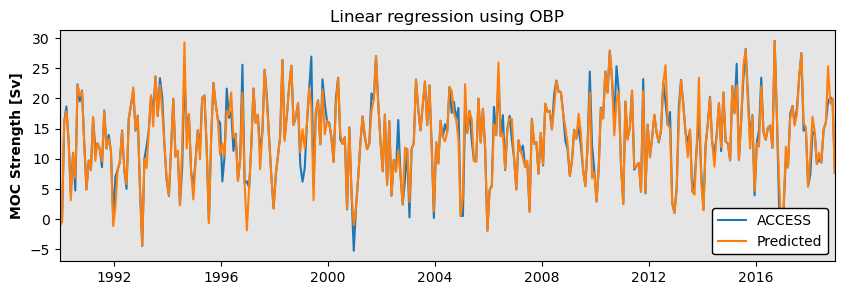

[[1.         0.88468543]
 [0.88468543 1.        ]]
3.1834739347270316


(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Predicted MOC Strength [Sv]', ylabel='ACCESS MOC Strength [Sv]'>)

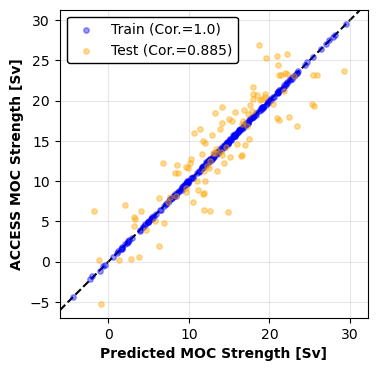

In [6]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse

linreg = linear_model.LinearRegression()

linreg.fit(x_train, y_train)

timeseries_comparison(linreg.predict(x)*1e-6, y*1e-6, x.time, len(x.time), 'ACCESS')
plt.title('Linear regression using OBP')
plt.show()

print(np.corrcoef(linreg.predict(x_test), y_test))
print(np.sqrt(mse(linreg.predict(x_test), y_test))*1e-6)

pred_vs_actual(linreg.predict(x_train)*1e-6, linreg.predict(x_test)*1e-6, y_train*1e-6, y_test*1e-6, 'ACCESS')

[[1.         0.80769715]
 [0.80769715 1.        ]]


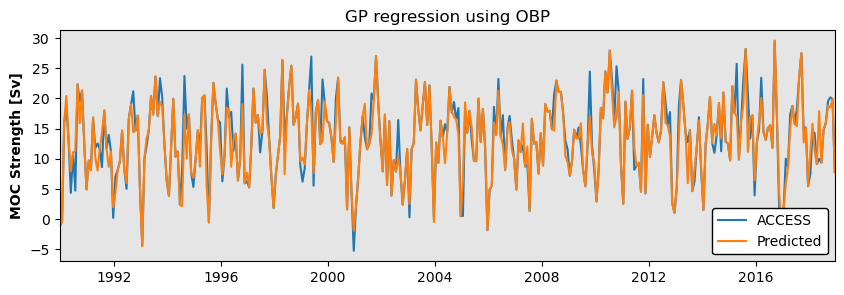

[[1.         0.80769715]
 [0.80769715 1.        ]]
4.196625518699825


(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Predicted MOC Strength [Sv]', ylabel='ACCESS MOC Strength [Sv]'>)

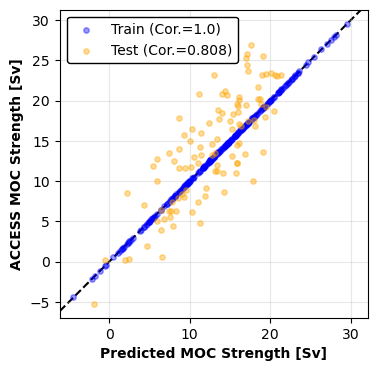

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp = GaussianProcessRegressor()
gp.fit(x_train.to_numpy(), y_train.to_numpy())
print(np.corrcoef(gp.predict(x_test.to_numpy()), y_test.to_numpy()))

# plt.plot(x_test.time, gp.predict(x_test.to_numpy())*1e-6, label='Fitted line (GP)')


timeseries_comparison(gp.predict(x)*1e-6, y*1e-6, x.time, len(x.time), 'ACCESS')
plt.title('GP regression using OBP')
plt.show()

print(np.corrcoef(gp.predict(x_test), y_test))
print(np.sqrt(mse(gp.predict(x_test), y_test))*1e-6)

pred_vs_actual(gp.predict(x_train)*1e-6, gp.predict(x_test)*1e-6, y_train*1e-6, y_test*1e-6, 'ACCESS')


First attempt at ESN

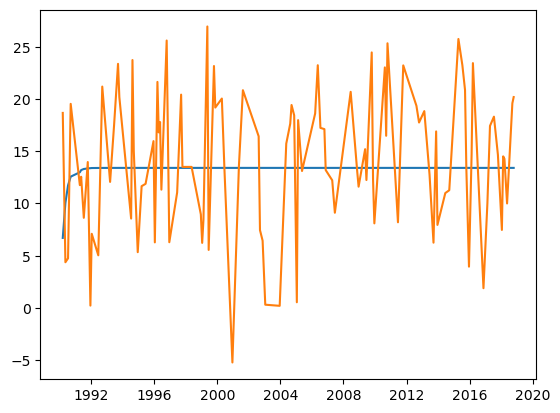

In [21]:
from ESN import ESN

res_model = ESN(3600, 100, 'full', 'full', 20)
res_model.fit(x_train.to_numpy(), y_train.to_numpy())

plt.plot(x_test.time, res_model.predict(x_test.to_numpy())*1e-6, label='Fitted line (ESN)')
plt.plot(x_test.time, y_test*1e-6, label='Actual MOC')

MLPs (Solodoch architecture included)

In [9]:
import torch

x_tensor = torch.from_numpy(x.to_numpy()).to(torch.float32)
y_tensor = torch.from_numpy(y.to_numpy()).to(torch.float32)

print(x_tensor.dtype)

MLPs_1L = [MLP(3600, 1, i+1, 0) for i in range(5)]

for i, mlp in enumerate(MLPs_1L):
    train_model(mlp, f'solo_{i+1}_OBP', x_tensor, y_tensor, '../ACCESS')

###### 2 layers
    
MLPs_2L = [MLP(3600, 2, i+1, 0) for i in range(5)]

for i, mlp in enumerate(MLPs_2L):
    train_model(mlp, f'2L_MLP_{i+1}_OBP', x_tensor, y_tensor, '../ACCESS')

###### 3 layers
    
MLPs_3L = [MLP(3600, 3, i+1, 0) for i in range(5)]

for i, mlp in enumerate(MLPs_3L):
    train_model(mlp, f'3L_MLP_{i+1}_OBP', x_tensor, y_tensor, '../ACCESS')

torch.float32
device: cpu
3603 parameters.


100%|██████████| 5000/5000 [00:04<00:00, 1106.48it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/solo_1_OBP.pt
final RMSE loss: 15.462701093757197 Sv
model saved to ../ACCESS/saved_models/solo_1_OBP.pt
loss curve saved to ../ACCESS/loss_curves/solo_1_OBP.png
device: cpu
7205 parameters.


100%|██████████| 5000/5000 [00:04<00:00, 1054.13it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/solo_2_OBP.pt
final RMSE loss: 4.963750405792781 Sv
model saved to ../ACCESS/saved_models/solo_2_OBP.pt
loss curve saved to ../ACCESS/loss_curves/solo_2_OBP.png
device: cpu
10807 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 992.85it/s] 


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/solo_3_OBP.pt
final RMSE loss: 14.563610097675642 Sv
model saved to ../ACCESS/saved_models/solo_3_OBP.pt
loss curve saved to ../ACCESS/loss_curves/solo_3_OBP.png
device: cpu
14409 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 936.46it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/solo_4_OBP.pt
final RMSE loss: 5.0435059432073635 Sv
model saved to ../ACCESS/saved_models/solo_4_OBP.pt
loss curve saved to ../ACCESS/loss_curves/solo_4_OBP.png
device: cpu
18011 parameters.


100%|██████████| 5000/5000 [00:06<00:00, 823.71it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/solo_5_OBP.pt
final RMSE loss: 14.56363889753931 Sv
model saved to ../ACCESS/saved_models/solo_5_OBP.pt
loss curve saved to ../ACCESS/loss_curves/solo_5_OBP.png
device: cpu
3605 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 836.20it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/2L_MLP_1_OBP.pt
final RMSE loss: 15.17242551445905 Sv
model saved to ../ACCESS/saved_models/2L_MLP_1_OBP.pt
loss curve saved to ../ACCESS/loss_curves/2L_MLP_1_OBP.png
device: cpu
7211 parameters.


100%|██████████| 5000/5000 [00:06<00:00, 753.97it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/2L_MLP_2_OBP.pt
final RMSE loss: 6.649070371824319 Sv
model saved to ../ACCESS/saved_models/2L_MLP_2_OBP.pt
loss curve saved to ../ACCESS/loss_curves/2L_MLP_2_OBP.png
device: cpu
10819 parameters.


100%|██████████| 5000/5000 [00:06<00:00, 724.97it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/2L_MLP_3_OBP.pt
final RMSE loss: 6.337774498663075 Sv
model saved to ../ACCESS/saved_models/2L_MLP_3_OBP.pt
loss curve saved to ../ACCESS/loss_curves/2L_MLP_3_OBP.png
device: cpu
14429 parameters.


100%|██████████| 5000/5000 [00:07<00:00, 657.55it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/2L_MLP_4_OBP.pt
final RMSE loss: 8.076663665663935 Sv
model saved to ../ACCESS/saved_models/2L_MLP_4_OBP.pt
loss curve saved to ../ACCESS/loss_curves/2L_MLP_4_OBP.png
device: cpu
18041 parameters.


100%|██████████| 5000/5000 [00:07<00:00, 649.28it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/2L_MLP_5_OBP.pt
final RMSE loss: 15.882207649225593 Sv
model saved to ../ACCESS/saved_models/2L_MLP_5_OBP.pt
loss curve saved to ../ACCESS/loss_curves/2L_MLP_5_OBP.png
device: cpu
3605 parameters.


100%|██████████| 5000/5000 [00:07<00:00, 708.66it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/3L_MLP_1_OBP.pt
final RMSE loss: 16.436709070656693 Sv
model saved to ../ACCESS/saved_models/3L_MLP_1_OBP.pt
loss curve saved to ../ACCESS/loss_curves/3L_MLP_1_OBP.png
device: cpu
7211 parameters.


100%|██████████| 5000/5000 [00:07<00:00, 667.93it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/3L_MLP_2_OBP.pt
final RMSE loss: 15.80042658058674 Sv
model saved to ../ACCESS/saved_models/3L_MLP_2_OBP.pt
loss curve saved to ../ACCESS/loss_curves/3L_MLP_2_OBP.png
device: cpu
10819 parameters.


100%|██████████| 5000/5000 [00:07<00:00, 665.76it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/3L_MLP_3_OBP.pt
final RMSE loss: 15.046408883230045 Sv
model saved to ../ACCESS/saved_models/3L_MLP_3_OBP.pt
loss curve saved to ../ACCESS/loss_curves/3L_MLP_3_OBP.png
device: cpu
14429 parameters.


100%|██████████| 5000/5000 [00:07<00:00, 658.69it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/3L_MLP_4_OBP.pt
final RMSE loss: 6.963388533918239 Sv
model saved to ../ACCESS/saved_models/3L_MLP_4_OBP.pt
loss curve saved to ../ACCESS/loss_curves/3L_MLP_4_OBP.png
device: cpu
18041 parameters.


100%|██████████| 5000/5000 [00:08<00:00, 609.47it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/3L_MLP_5_OBP.pt
final RMSE loss: 7.792490098952452 Sv
model saved to ../ACCESS/saved_models/3L_MLP_5_OBP.pt
loss curve saved to ../ACCESS/loss_curves/3L_MLP_5_OBP.png
